# Full Train Workflow

Run when you need to train a new classifier from scratch. Will regenerate transient data, refit all samples, and retrain the classifier.

## Step 0: Update configuration file.

In the same folder as this notebook, there is a $\texttt{config.yaml}$ file, which contains all filepaths and configuration options for the training workflow. Please update this now!

The most important filepath arguments are:
* $\texttt{create-dirs}$: Probably keep set to True. Create any data subdirectories that are missing.
* $\texttt{data-dir}$: This is where all generated data is stored. Set to the root directory for all outputs.
* $\texttt{relative-dirs}$: If true, all data for each step is stored within subdirectories of data_dir.
* $\texttt{transient-data-fn}$: This is where all transient data is stored as a TransientGroup. Technically a directory but loaded as a single file. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{sampler-results-fn}$: Where light curve fits are stored. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{figs-dir}$: Where all figures are stored (only generated if $\texttt{plot}$ is set to True). If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{models-dir}$: Where all classification models are stored. If relative_dirs is True, is created as a subdirectory of data_dir.

The most important sampling and classifier arguments are:
* $\texttt{sampler}$: Set to either dynesty or svi (all lowercase). SVI is faster but forces the posterior into a multivariate Gaussian.
* $\texttt{model-type}$: Set to either LightGBM (recommended) or MLP.
* $\texttt{use-redshift-features}$: If True, includes peak absolute magnitude and redshift as training features.
* $\texttt{fits-per-majority}$: Oversamples such that the majority class has this many samples fed into the classifier. Minority classes will correspond to more input samples per event. Defaults to 5.
* $\texttt{target-label}$: For binary classification - this is the positive label. Set to None for multiclass classification.
* $\texttt{n-folds}$: Number of K-folds. I usually set to 10.
* $\texttt{num-epochs}$: Number of estimators for LightGBM or number of training epochs for MLP.
* $\texttt{n-parallel}$: Number of threads to parallelize data import + sampling over.
* $\texttt{random-seed}$: For reproducibility.

## Step 1: Generate new TransientSet

Here we will import data from TNS + ALeRCE and generate a new TransientSet, from a list of event names. Names can be from TNS or ZTF.

The below code block will retrieve all spectroscopically classified TNS transients. Feel free to change to your own list of names or import script.

In [1]:
from snapi.query_agents import TNSQueryAgent
tns_agent = TNSQueryAgent()
tns_agent.update_local_database() # IMPORTANT: run this line if first time using SNAPI or if you want to reimport TNS csv
all_names = tns_agent.retrieve_all_names() # only spectroscopically classified
print(len(all_names), all_names[:5])

curl -X POST -H 'user-agent: tns_marker{"tns_id":126596,"type": "bot", "name":"PSUBOT"}' -d "api_key=1f667ea007d79f16fbf001bd33e019e47b548140" https://www.wis-tns.org/system/files/tns_public_objects/tns_public_objects.csv.zip > /Users/kdesoto/python_repos/snapi/data/tns_public_objects.csv.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9965k    0 9965k  100    48  4507k     21  0:00:02  0:00:02 --:--:-- 4509k


17851 ['20210924D' '2024adfy' '2024adcf' '2024acrz' '2024acnp']


The following script will import data for all provided names and generate a TransientGroup object. Will run in parallel across n_cores threads.

For the entire TNS dataset (~16000 events), this takes ~30 minutes on 8 parallel cores.

In [ ]:
from superphot_plus.config import SuperphotConfig
from superphot_plus.data_generation import import_all_names

config = SuperphotConfig.from_file("config.yaml")
save_dir = config.transient_data_fn

# import data for all_names from query agents
import_all_names(
    all_names, save_dir,
    checkpoint_freq=1024,
    n_cores=config.n_parallel,
    overwrite=False
) # set overwrite=False to continue from where left off

13456 names to query across 8 cores.
Processing 1036 transients in batch


Finished processing, making transient group now
Total transients saved: 1365.
Processing 1035 transients in batch
Finished processing, making transient group now
Total transients saved: 1832.
Processing 1035 transients in batch


Finished processing, making transient group now
Total transients saved: 2331.
Processing 1035 transients in batch


Finished processing, making transient group now
Total transients saved: 2821.
Processing 1035 transients in batch


Finished processing, making transient group now
Total transients saved: 3331.
Processing 1035 transients in batch
Finished processing, making transient group now
Total transients saved: 3831.
Processing 1035 transients in batch


Finished processing, making transient group now
Total transients saved: 4339.
Processing 1035 transients in batch
Finished processing, making transient group now
Total transients saved: 4784.
Processing 1035 transients in batch
Finished processing, making transient group now
Total transients saved: 5187.
Processing 1035 transients in batch


Finished processing, making transient group now
Total transients saved: 5707.
Processing 1035 transients in batch


Finished processing, making transient group now
Total transients saved: 6239.
Processing 1035 transients in batch


Finished processing, making transient group now
Total transients saved: 6723.
Processing 1035 transients in batch


Finished processing, making transient group now
Total transients saved: 7202.


In [ ]:
# Let's check the TransientGroup we created!
from snapi import TransientGroup
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)

print(len(transient_group.metadata))
print(transient_group.metadata.head())

7202
                 ra        dec                   internal_names spec_class  \
id                                                                           
2016blu  188.967917  27.932083  Gaia16ada, ZTF17aaapufz, XM13MZ        LBV   
2016cya  267.340754  19.739722            ZTF18abckxfb, PS16cwf         CV   
2016dto  261.583750   6.271917          Gaia16agr, ZTF18ablwqqf    Varstar   
2016ewr  275.658571  12.438262          kait-16au, ZTF18abnvuya         CV   
2016hvq  326.893282 -25.792681        ZTF20abnsqsr, ASASSN-16mx         CV   

         redshift  
id                 
2016blu   0.00261  
2016cya       NaN  
2016dto   0.00000  
2016ewr       NaN  
2016hvq       NaN  


Finally, before fitting, we want to phase and normalize all the photometry. This is because our samplers expect light curves to already be phased and normalized before fitting.

In [ ]:
from snapi import TransientGroup
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
new_transients = []
for i, t in enumerate(transient_group):
    if i % 1000 == 0:
        print(f"Preprocessed {i} out of {len(transient_group)} transients.")
    t.photometry.phase(inplace=True)
    t.photometry.normalize(inplace=True)
    new_transients.append(t)

new_transient_group = TransientGroup(new_transients)
new_transient_group.save(config.transient_data_fn)

Preprocessed 0 out of 7202 transients.
Preprocessed 1000 out of 7202 transients.
Preprocessed 2000 out of 7202 transients.
Preprocessed 3000 out of 7202 transients.
Preprocessed 4000 out of 7202 transients.
Preprocessed 5000 out of 7202 transients.
Preprocessed 6000 out of 7202 transients.
Preprocessed 7000 out of 7202 transients.


## Step 2 (Option 1): Fit all transients using SVI (faster)

Here, we choose to fit our transients using stochastic variational inference (SVI). If using this option, make sure sampler='superphot_svi' in the config.yaml file. This option is faster but assumes Gaussianity of the posterior space, which can be limiting for certain light curve fits.

For all 7202 TNS transients passing quality cuts, this takes ~30 minutes.

In [ ]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig
import shutil
import os

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

result = fit_transient_group(
    transient_group,
    sampler = svi_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = config.sampler_results_fn,
    checkpoint_freq = 512,
    pad=True,
    overwrite=False # set to False to continue where left off
)
SamplerResultGroup(result).save(config.sampler_results_fn)

# backup for later augmentation
shutil.copytree(
    config.sampler_results_fn, 
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

Transient group loaded


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:37:02,447 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:37:02,447 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:37:02,448 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:37:02,448 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 0 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:39:08,762 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:39:08,762 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:39:08,762 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:39:08,762 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 1 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:41:01,560 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:41:01,560 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:41:01,560 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:41:01,560 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 2 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:43:04,155 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:43:04,155 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:43:04,157 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Finished checkpoint 3 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:44:56,432 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:44:56,432 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:44:56,432 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:44:56,432 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 4 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:47:00,449 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:47:00,450 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:47:00,450 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:47:00,450 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 5 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:48:52,330 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:48:52,330 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:48:52,331 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:48:52,332 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 6 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:50:41,136 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:50:41,136 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:50:41,136 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:50:41,137 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'li

Finished checkpoint 7 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:53:06,902 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:53:06,904 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:53:06,904 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:53:06,904 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 8 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:54:59,054 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:54:59,054 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:54:59,054 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:54:59,055 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 9 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:56:56,659 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:56:56,659 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:56:56,660 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:56:56,660 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 10 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 19:59:02,526 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:59:02,526 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:59:02,526 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 19:59:02,526 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 11 of 13


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 20:01:04,593 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 20:01:04,594 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 20:01:04,595 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 20:01:04,595 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 12 of 13


'/Users/kdesoto/superphot-plus-data/tmp_sampler_results'

         A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                               
2016blu        0.596752           0.000226           17.266319   
2016cya        1.033747           0.004010           10.239975   
2016dto        0.699464           0.000629           30.157688   
2016ewr        1.029870           0.004950           23.929132   
2016hvq        0.960197           0.004499           27.916416   
...                 ...                ...                 ...   
2024ws         1.576443           0.004569          108.200439   
2024xh         0.968204           0.008498           20.228596   
2024xx         1.059008           0.004813           16.466484   
2024ym         1.189234           0.005576            9.680868   
2024yr         1.137264           0.008132           20.436127   

         t_0_ZTF_r_median  tau_rise_ZTF_r_median  tau_fall_ZTF_r_median  \
id                                                                

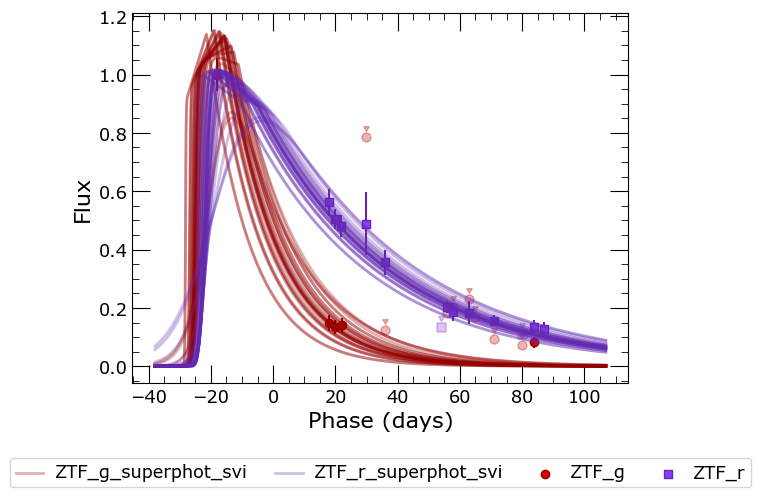

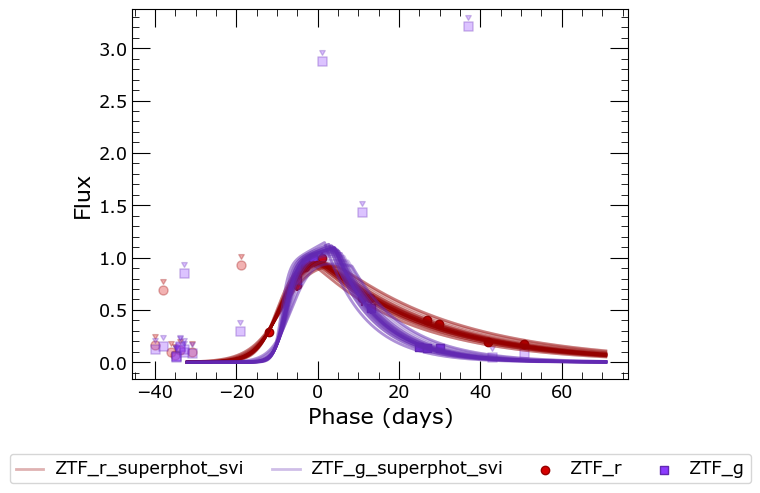

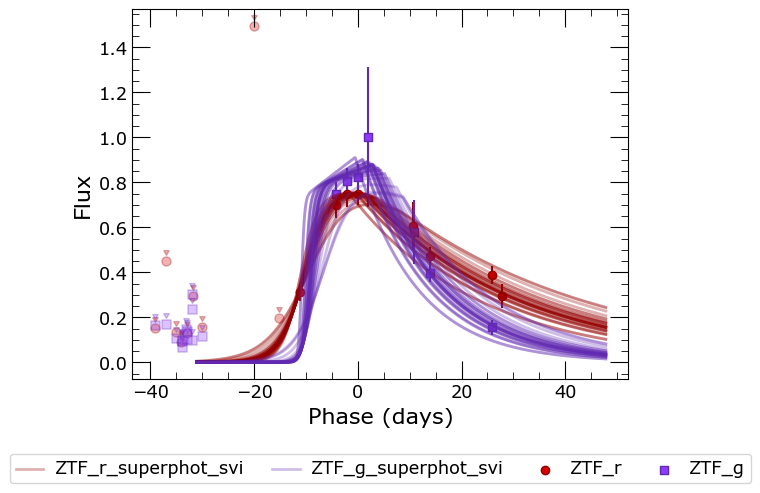

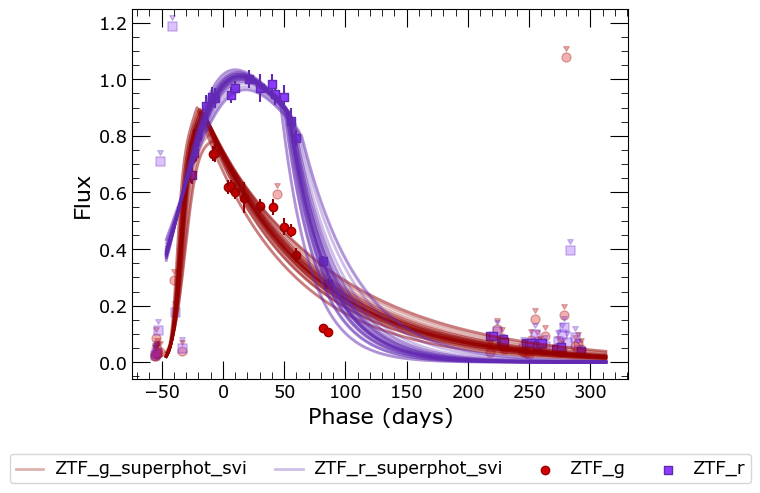

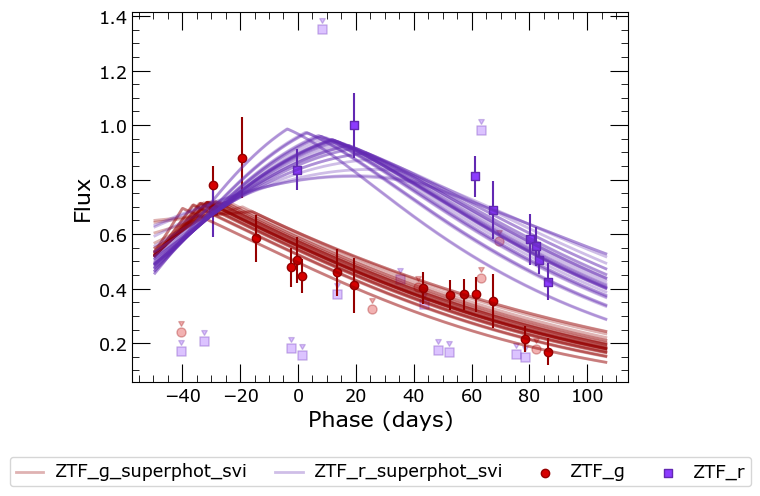

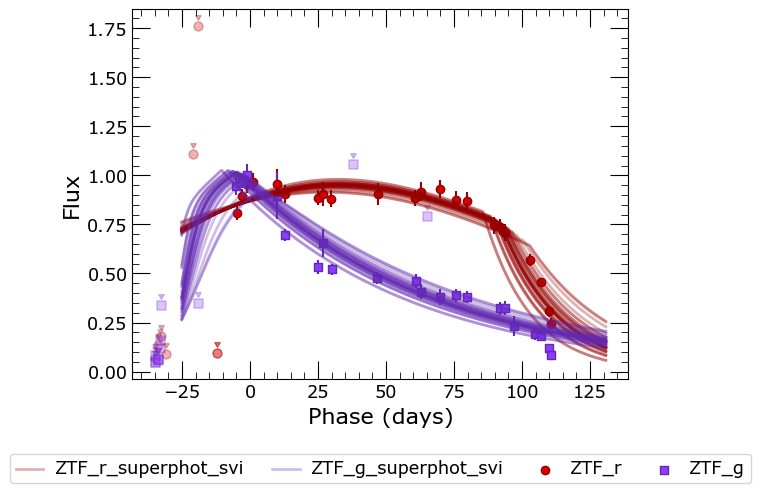

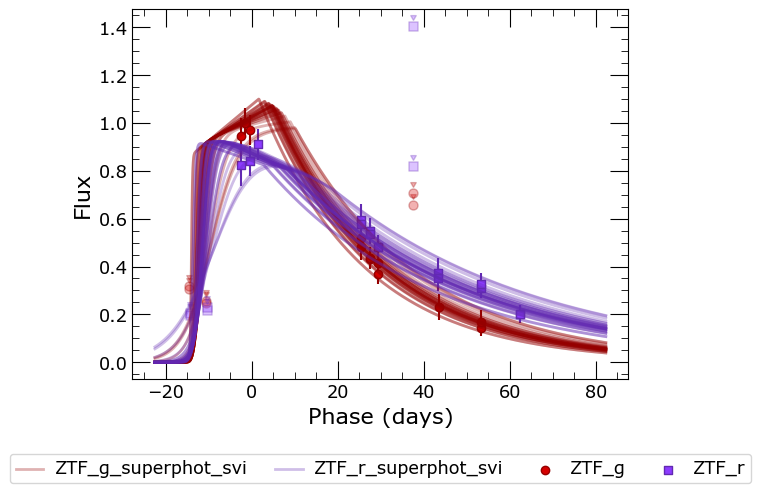

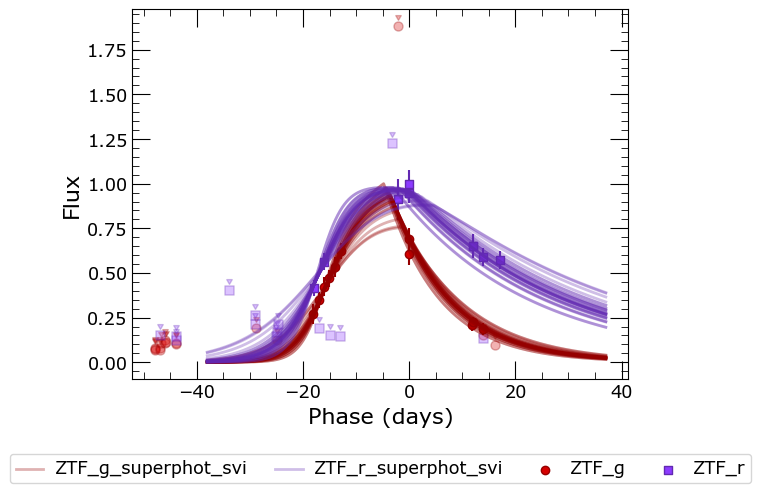

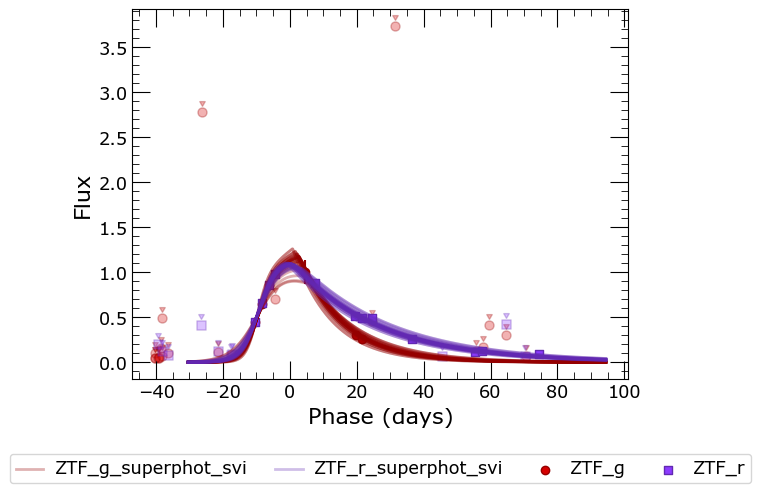

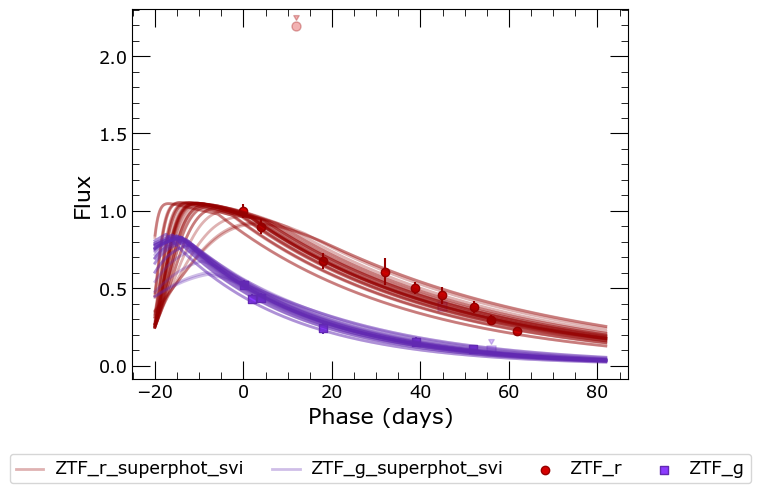

In [ ]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(config.sampler_results_fn)

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

print(sampler_results.metadata)
names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]:
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2 (Option 2): Fit light curves using dynesty (slower)

Here, we fit our transient photometry using the dynesty nested sampler. This is slower but does not assume Gaussianity of the posterior space, so can better capture degeneracies between parameters. If you use this, make sure to set sampler=superphot_dynesty in the config.yaml file.

Runtime for 7202 TNS samples: ~200 minutes (3.5 hours)

In [ ]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

priors = generate_priors(["ZTF_r","ZTF_g"])

dynesty_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

result = fit_transient_group(
    transient_group,
    sampler = dynesty_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = config.sampler_results_fn,
    checkpoint_freq = 128,
    pad=False,
    overwrite=True, # False to continue from checkpoint
)
SamplerResultGroup(result).save(config.sampler_results_fn)

# backup for later augmentation
shutil.copytree(
    config.sampler_results_fn, 
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)


Transient group loaded


/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:33:39,406 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:33:39,406 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03

Finished checkpoint 0 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 1 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 2 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,389 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 3 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:47:44,712 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,713 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,714 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,715 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 4 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,465 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 5 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()


KeyboardInterrupt: 

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(


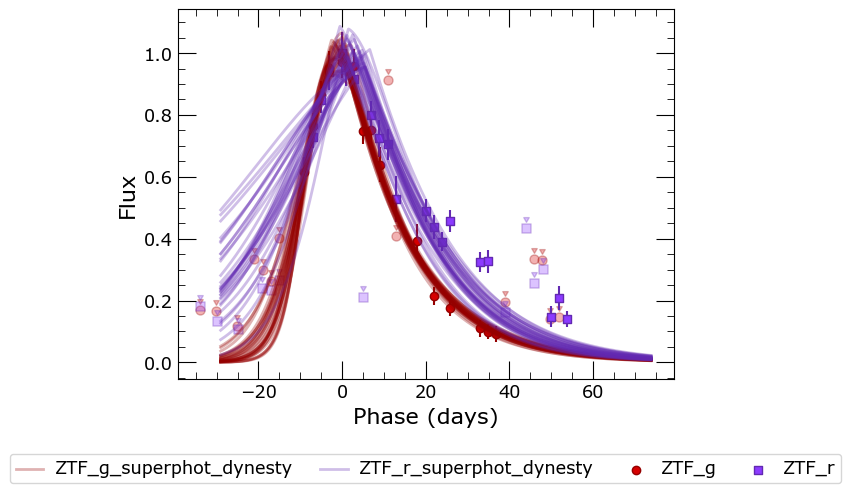

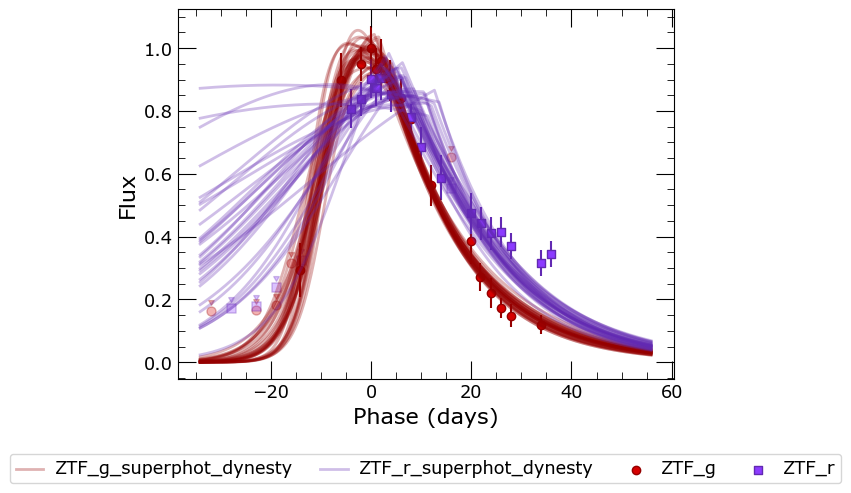

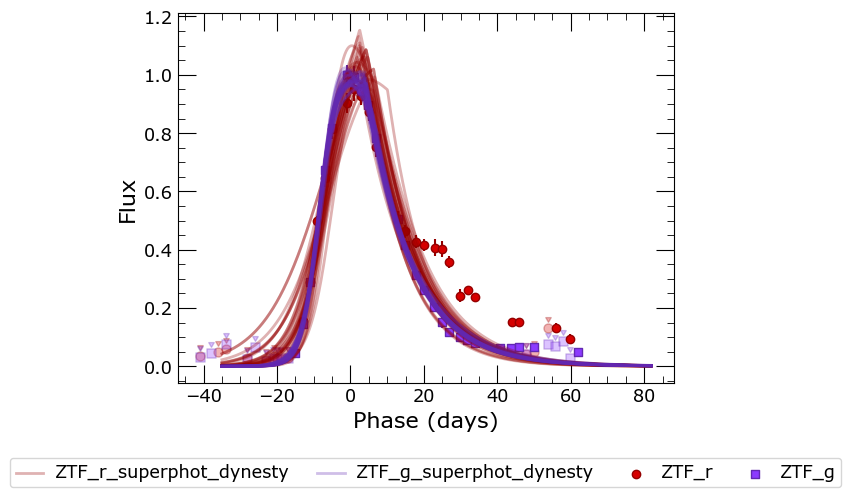

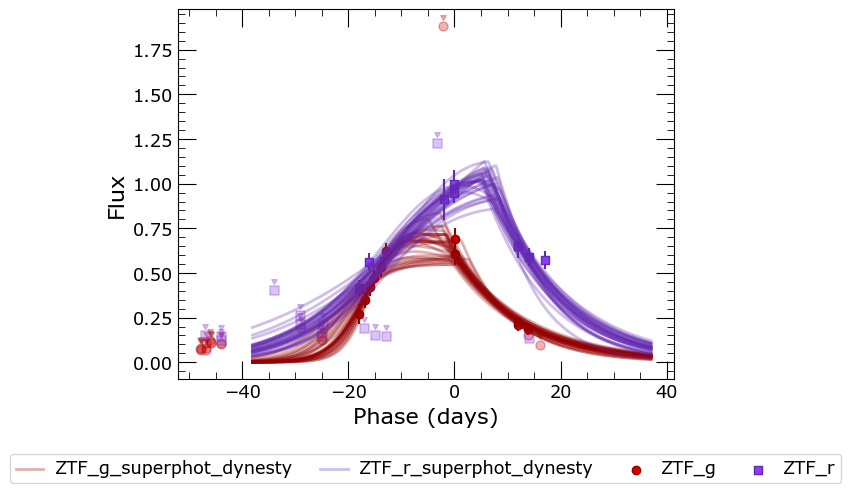

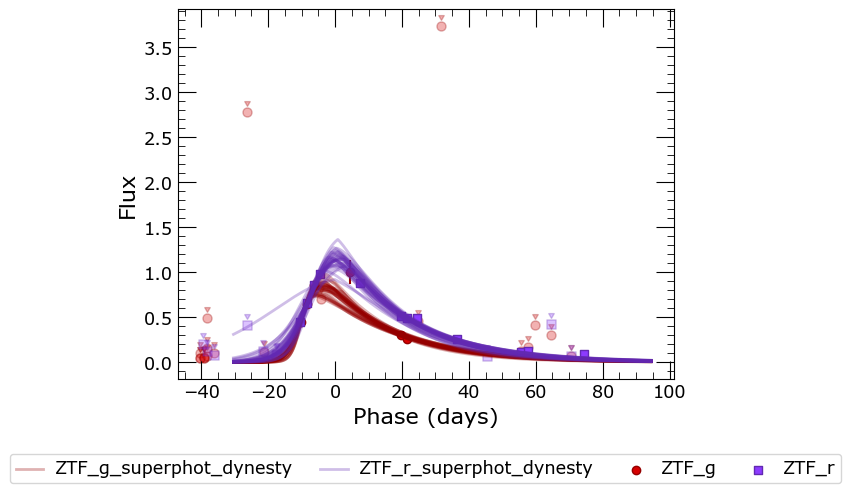

In [ ]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(config.sampler_results_fn)

priors = generate_priors(["ZTF_r","ZTF_g"])

svi_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]: # neweet 
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)

    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2.5: Convert SamplerResultGroup posteriors back to uncorrelated Gaussians

When sampling, the posteriors are saved as the inputs to our flux model. The Gaussian priors, however, were converted to log-Gaussians and multiplied by base parameters where necessary before being fed into the model function. Therefore, we must revert these log-Gaussian and relative parameters back to their original uncorrelated Gaussian draws before using as classifier inputs. We do this below:

In [ ]:
# warning: only run once!
import os
from snapi import SamplerResultGroup
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

new_sr = []
for i, sr in enumerate(sampler_results):
    if i % 1000 == 0:
        print(f"Converted {i} out of {len(sampler_results)} fits")
    columns = sr.fit_parameters.columns
    columns = columns[columns != 'score']
    fp = sr.fit_parameters
    fp.loc[:, columns] = priors.reverse_transform(fp.loc[:, columns])
    sr.fit_parameters = fp
    new_sr.append(sr)
    
new_sampler_results = SamplerResultGroup(new_sr)
new_sampler_results.save(config.sampler_results_fn)


Converted 0 out of 7202 fits
Converted 1000 out of 7202 fits
Converted 2000 out of 7202 fits
Converted 3000 out of 7202 fits
Converted 4000 out of 7202 fits
Converted 5000 out of 7202 fits
Converted 6000 out of 7202 fits
Converted 7000 out of 7202 fits


## Step 3: Train classifier from sampling posteriors

Here we train a classifier with our uncorrelated posterior features. This script will automatically split the data into K-folds, oversample the training and validation sets to even out minority classes, and train either LightGBMs (recommended) or MLPs. If plot is True, metric plots and confusion matrices will also be generated.

In [ ]:
from superphot_plus import SuperphotConfig, SuperphotTrainer

config = SuperphotConfig.from_file("config.yaml")
trainer = SuperphotTrainer(config)
trainer.run()

2024-12-05 17:47:40,256 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-05 17:47:40,258 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 1.062 | Train Acc: 59.55%
	 Val. Loss: 0.939 |  Val. Acc: 68.90%
Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.096 | Train Acc: 58.10%
	 Val. Loss: 0.762 |  Val. Acc: 74.51%
Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.067 | Train Acc: 59.47%
	 Val. Loss: 0.865 |  Val. Acc: 65.85%
Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.085 | Train Acc: 58.59%
	 Val. Loss: 0.809 |  Val. Acc: 70.46%
Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.077 | Train Acc: 58.50%
	 Val. Loss: 0.828 |  Val. Acc: 69.48%
Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.089 | Train Acc: 57.89%
	 Val. Loss: 0.735 |  Val. Acc: 71.80%
Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.089 | Train Acc: 57.86%
	 Val. Loss: 0.772 |  Val. Acc: 72.50%
Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.081 | Train Acc: 57.97%
	 Val. Loss: 0.778 |  Val. Acc: 70.16%
Epoch: 26 | Epoch Time: 0m 3s
	Train Loss: 0.823 | Train Acc: 70.11%
	 Val. Loss: 0.667 |  Val. Acc: 79.57%
Epoch: 26 | Epoch Time: 0m 3